# DECISION TREE MODEL BUILD

## Importing required libraries

In [143]:
import psutil
import time
import joblib
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


## Load Train and Test Datasets

In [144]:
df_train = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

In [145]:
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [146]:
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

In [147]:
X_train, X_train_test, y_train, y_train_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Track system metrics before training

In [148]:
start_time = time.time()
cpu_before = psutil.cpu_percent(interval=None)
mem_before = psutil.virtual_memory().used
disk_before = psutil.disk_io_counters().write_bytes

# Apply SMOTE for class balancing

In [149]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Model Creation and Training

In [150]:
dt_model = DecisionTreeClassifier(
    criterion='gini',  # Gini Impurity for splits (alternatively, 'entropy' can be used)
    max_depth=5,     # Limiting depth to prevent overfitting
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42    # For reproducibility
    
)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

# Track system metrics after training

In [151]:
end_time = time.time()
cpu_after = psutil.cpu_percent(interval=None)
mem_after = psutil.virtual_memory().used
disk_after = psutil.disk_io_counters().write_bytes

# Compute computational overhead

In [152]:
execution_time = end_time - start_time
cpu_usage_change = cpu_after - cpu_before
memory_used = (mem_after - mem_before) / (1024 ** 2)  # Convert bytes to MB
disk_io_used = (disk_after - disk_before) / (1024 ** 2)  # Convert bytes to MB

# Extract Feature Importance (Gini Importance)

In [153]:

# Extract feature importance
feature_importance = dt_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display Top Features
print("Top 11 Important Features:\n", importance_df.head(14))


Top 11 Important Features:
                      Feature  Importance
4                  src_bytes    0.790523
41                     level    0.058512
1              protocol_type    0.055369
32        dst_host_srv_count    0.047638
5                  dst_bytes    0.020270
11                 logged_in    0.010247
33    dst_host_same_srv_rate    0.010171
38  dst_host_srv_serror_rate    0.003711
2                    service    0.001428
24               serror_rate    0.000750
22                     count    0.000648
34    dst_host_diff_srv_rate    0.000471
39      dst_host_rerror_rate    0.000196
26               rerror_rate    0.000067


# Visualizing Feature Importance

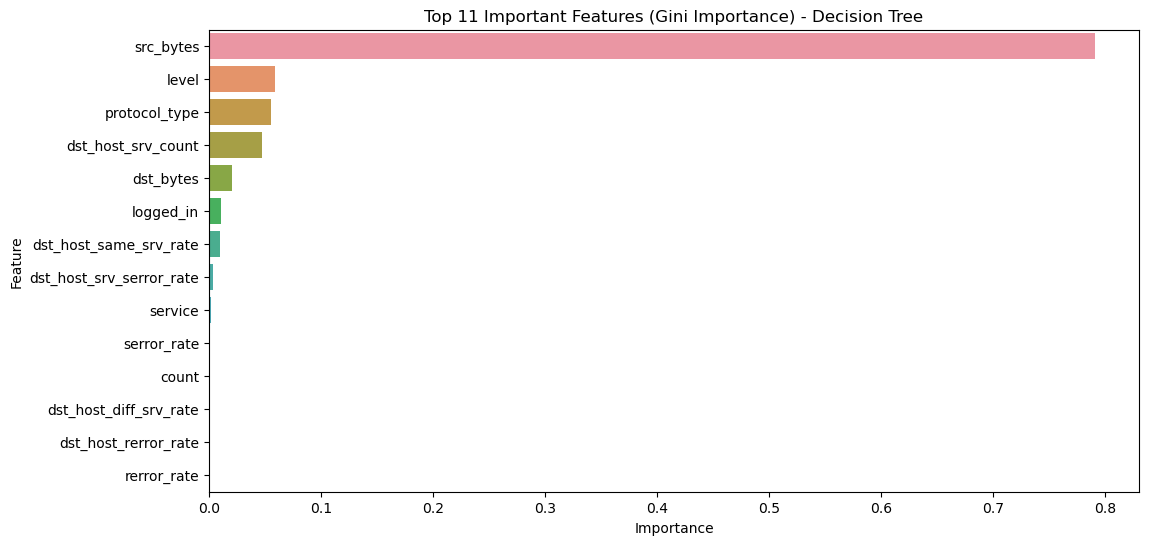

In [155]:
# Plot the top 11 important features
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'][:11], y=importance_df['Feature'][:14])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 11 Important Features (Gini Importance) - Decision Tree')
plt.show()


# Select Top Features and Retrain the Model

In [156]:
# Select top 10 important features
top_features = importance_df['Feature'][:14].values

# Reduce dataset to selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Retrain Decision Tree on Selected Features

In [157]:
# Train a new Decision Tree using only selected features
dt_selected_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42
)

dt_selected_model.fit(X_train_selected, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

# Evaluate the Model

In [158]:
start_pred_time = time.time()
# Predict on test set
y_test_pred_selected = dt_selected_model.predict(X_test_selected)

end_pred_time = time.time()

inference_time = (end_pred_time - start_pred_time) / len(X_test)  # Time per sample


# Compute accuracy
test_accuracy_selected = accuracy_score(y_test, y_test_pred_selected)
test_precision_selected = precision_score(y_test, y_test_pred_selected)
test_recall_selected = recall_score(y_test, y_test_pred_selected)
test_f1_selected = f1_score(y_test, y_test_pred_selected)

print("\nTest Metrics (Using Selected Features):")
print(f"Accuracy:   {test_accuracy_selected:.2%}")
print(f"Precision:  {test_precision_selected:.2%}")
print(f"Recall:     {test_recall_selected:.2%}")
print(f"F1-score:   {test_f1_selected:.2%}")



Test Metrics (Using Selected Features):
Accuracy:   88.02%
Precision:  80.57%
Recall:     95.15%
F1-score:   87.25%


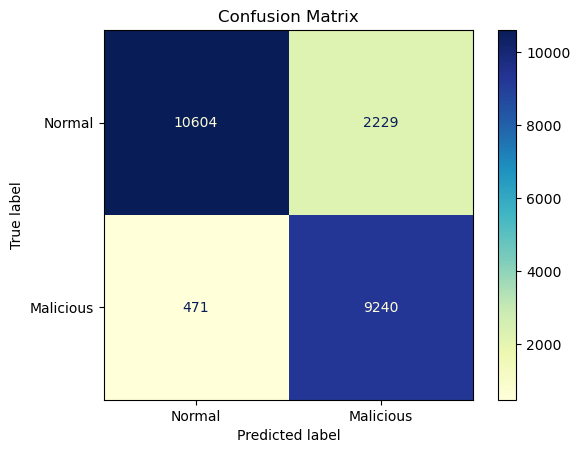

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     12833
           1       0.81      0.95      0.87      9711

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544



In [159]:
cm = confusion_matrix(y_test, y_test_pred_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malicious'])

disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_test_pred_selected))

## Save the trained model

In [160]:
import joblib
model_folder = "../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_DecisionTree.joblib"
model_path = model_folder + model_filename
joblib.dump(dt_selected_model, model_path)
print(f"Decision Tree model saved to: {model_path}")

Decision Tree model saved to: ../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/NSL-KDD_DecisionTree.joblib


In [161]:
# start_pred_time = time.time()
# y_test_pred = dt_model.predict(X_test)
# end_pred_time = time.time()
# inference_time = (end_pred_time - start_pred_time) / len(X_test)  

## Visualize the Decision Tree

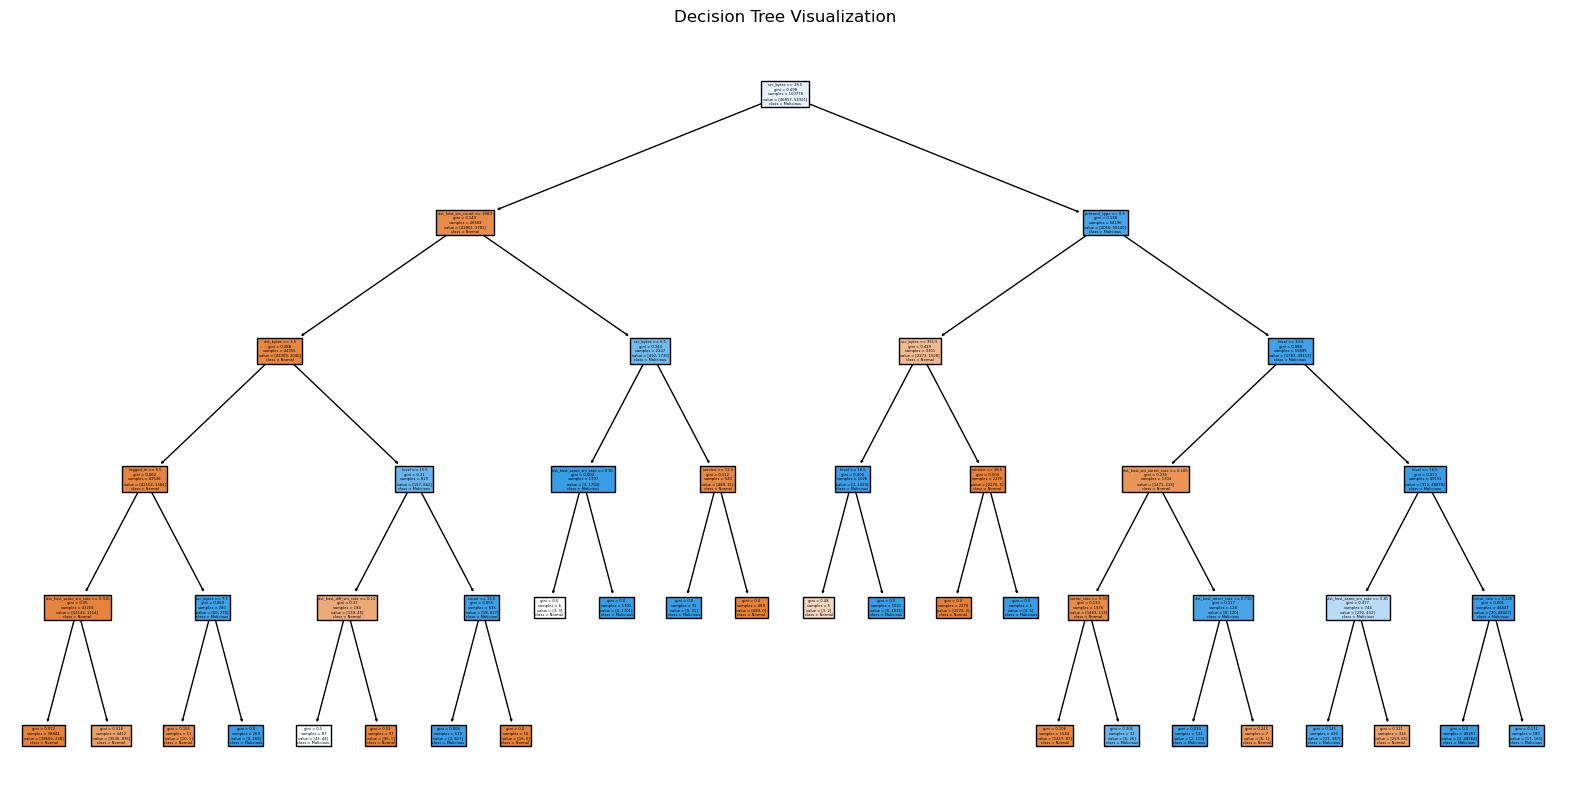

In [162]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=df_train.columns[:-1].tolist(), class_names=['Normal', 'Malicious'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()

# Compute tree complexity

In [163]:
num_nodes = dt_selected_model.tree_.node_count
max_depth = dt_selected_model.tree_.max_depth


print("\n🚀 **Computational Overhead Report** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"⚡ **Inference Time per Sample:** {inference_time:.6f} seconds")
print(f"🌳 **Decision Tree Complexity:**")
print(f"🧩 **Number of Nodes:** {num_nodes}")
print(f"📏 **Tree Depth:** {max_depth}")


🚀 **Computational Overhead Report** 🚀
⏳ **Execution Time:** 6.3769 seconds
🔥 **CPU Usage Change:** 25.50%
💾 **Disk I/O Usage:** 0.93 MB
📊 **Peak Memory Usage:** 24.51 MB
⚡ **Inference Time per Sample:** 0.000000 seconds
🌳 **Decision Tree Complexity:**
🧩 **Number of Nodes:** 47
📏 **Tree Depth:** 5


# Scalability Test

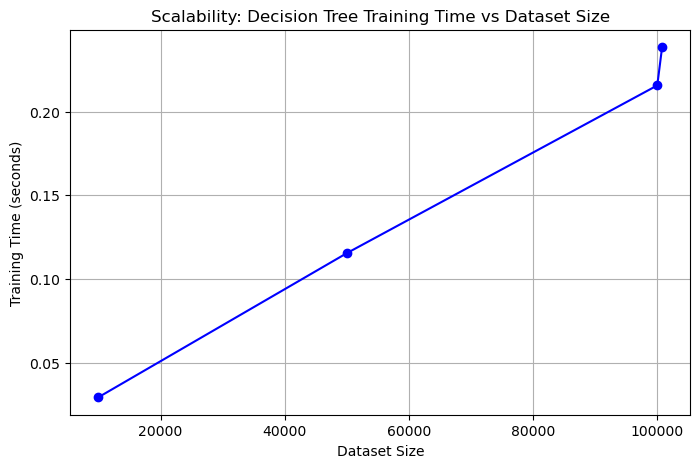

                          Metric         Value
0             Execution Time (s)  6.376885e+00
1           CPU Usage Change (%)  2.550000e+01
2               Memory Used (MB)  2.451172e+01
3            Disk I/O Usage (MB)  9.296875e-01
4  Inference Time per Sample (s)  1.862487e-07
5                Number of Nodes  4.700000e+01
6                     Tree Depth  5.000000e+00


In [164]:
sizes = [10_000, 50_000, 100_000, len(X_train)]
train_times = []

for size in sizes:
    X_sample, y_sample = X_train[:size], y_train[:size]
    start_time = time.time()
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_sample, y_sample)
    train_times.append(time.time() - start_time)

# Plot execution time
plt.figure(figsize=(8, 5))
plt.plot(sizes, train_times, marker='o', linestyle='-', color='b')
plt.xlabel("Dataset Size")
plt.ylabel("Training Time (seconds)")
plt.title("Scalability: Decision Tree Training Time vs Dataset Size")
plt.grid()
plt.show()

# Save evaluation results
results = {
    "Metric": [
        "Execution Time (s)",
        "CPU Usage Change (%)",
        "Memory Used (MB)",
        "Disk I/O Usage (MB)",
        "Inference Time per Sample (s)",
        "Number of Nodes",
        "Tree Depth"
    ],
    "Value": [
        execution_time,
        cpu_usage_change,
        memory_used,
        disk_io_used,
        inference_time,
        num_nodes,
        max_depth
    ]
}

df_results = pd.DataFrame(results)

# Print results
print(df_results)

# Optionally, save to CSV
df_results.to_csv("decision_tree_computational_overhead.csv", index=False)